# Dimensionality Reduction (PCA) and Clustering

Select / generate appropriate features, pre-process data (standardize, scale), apply PCA, use reduced data to find clusters. 

In this notebook I have tried three scaled variants for normalization / feature transformation and then applied (& visualized) PCA to them:
- log
- box-cox (with a little work-around to handle the many 0 values)
- yeo-johnson (handles non-positive values)

It was interesting to see how they resulted in somewhat different patterns. I then chose log and box-cox for further experimentation because I visualy saw more clustering potential in their respective bi-plots.

I tried to cluster with 4 and 2 PCA-dimensions, the latter performing much better. I also tried to whiten the data, but that did not work at all. I then clustered with k-means and hierarchical clustering, whose avg linkage scored nearly as good as k-means (there is a visualization of the hierarchies far below). Log outscored box-cox in all variants.

Best shilhouette score was recorded for k-means with 4 clusters on 2D-reduced, scaled log_transformed data, but such a low number of segments would not really have helped much, so I went for 2nd best score with 12 clusters.

The results are pretty impressive.

I also have to say that I revisited my features several times and constructed some additional ratios.


(An earlier version of this notebook is saved in the main folder, it contains more experiments considering preprocessing (normalization and scaling), pca-analysis and clustering - just for future reference. Note: It is based on a different set of input features, probably not as good as this one, and I did not transform all of the features.)

### Data Sources

Cleaned datafile `profile_type_clean.csv` as prepared in notebook 1.

### Changes

- 2019-01-29: Start notebook as copy of earlier version and finalize clustering. 


In [1]:
# load libraries

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.preprocessing import minmax_scale, maxabs_scale, robust_scale, StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# my own custom functions
import EDA_functions as EDA
import cleaning_functions as cleaning

# visualization
import matplotlib.pyplot as plt
import seaborn as sns #, sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# display settings
from IPython.display import display
pd.options.display.max_columns = None

from pathlib import Path  # to make file path references relative to notebook directory

In [2]:
# import preparated data

profile_type_file = Path.cwd() / "data" / "processed" / "profile_type_clean.csv"
profile_type = pd.read_csv(profile_type_file, index_col = 0, dtype={'gender' : 'category'})

## Construct dataset for clustering

We will try to find cluster based on customer behaviour only, this means that socio-demographic features will be removed from the data set.

In [3]:
display(profile_type)
display(profile_type.info())

,age,gender,income,member_days,offer_received,offer_viewed,offer_completed,viewed_received,completed_viewed,total_trans,total_amount,total_reward,total_profit,prop_reward,total_mean_amount,np_trans,np_amount,np_mean_amount,prop_np_trans,prop_np_amount,bogo_completed,bogo_viewed,bogo_trans,bogo_amount,discount_completed,discount_viewed,discount_trans,discount_amount,info_viewed,info_trans,info_amount,prop_bogo_amount,prop_discount_amount,prop_info_amount,bogo_vtc,discount_vtc
p_1,NaN,NaN,NaN,-529,5.0,5.0,2.0,1.000000,2.0,9.0,20.40,5.0,15.40,0.245098,2.266667,0,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000,2.0,5.0,9.0,20.400,0.0,0.0,0.000,0.000000,1.000000,0.000000,0.000000,0.400000
p_10,NaN,NaN,NaN,-611,4.0,3.0,1.0,0.750000,0.0,6.0,15.62,5.0,10.62,0.320102,2.603333,3,7.69,2.563333,0.500000,0.492318,0.0,2.0,3.0,7.930,0.0,0.0,0.0,0.000,1.0,0.0,0.000,0.507682,0.000000,0.000000,0.000000,0.000000
p_100,68.0,F,84000.0,-725,5.0,0.0,1.0,0.000000,0.0,2.0,34.04,2.0,32.04,0.058754,17.020000,2,34.04,17.020000,1.000000,1.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
p_1000,67.0,M,44000.0,-225,4.0,4.0,0.0,1.000000,0.0,5.0,19.78,0.0,19.78,0.000000,3.956000,2,13.37,6.685000,0.400000,0.675935,0.0,3.0,3.0,5.555,0.0,0.0,0.0,0.000,1.0,1.0,0.855,0.280839,0.000000,0.043225,0.000000,0.000000
p_10000,NaN,NaN,NaN,-446,3.0,3.0,0.0,1.000000,0.0,6.0,7.28,0.0,7.28,0.000000,1.213333,1,1.83,1.830000,0.166667,0.251374,0.0,2.0,4.0,3.935,0.0,1.0,3.0,1.515,0.0,0.0,0.000,0.540522,0.208104,0.000000,0.000000,0.000000
p_10001,56.0,F,71000.0,-716,5.0,5.0,4.0,1.000000,4.0,17.0,289.20,19.0,270.20,0.065698,17.011765,13,228.10,17.546154,0.764706,0.788728,1.0,1.0,1.0,7.310,3.0,3.0,4.0,53.790,1.0,0.0,0.000,0.025277,0.185996,0.000000,1.000000,1.000000
p_10002,69.0,M,62000.0,-977,2.0,0.0,1.0,0.000000,0.0,8.0,139.84,5.0,134.84,0.035755,17.480000,8,139.84,17.480000,1.000000,1.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
p_10003,66.0,F,74000.0,-72,3.0,2.0,2.0,0.666667,2.0,3.0,58.96,12.0,46.96,0.203528,19.653333,1,14.91,14.910000,0.333333,0.252883,1.0,1.0,1.0,15.090,1.0,1.0,1.0,28.960,0.0,0.0,0.000,0.255936,0.491180,0.000000,1.000000,1.000000
p_10004,64.0,M,53000.0,-54,5.0,4.0,0.0,0.800000,0.0,0.0,0.00,0.0,0.00,0.000000,0.000000,0,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000,0.0,4.0,0.0,0.000,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
p_10005,28.0,M,64000.0,-295,6.0,4.0,2.0,0.666667,2.0,7.0,19.34,4.0,15.34,0.206825,2.762857,3,8.01,2.670000,0.428571,0.414168,0.0,2.0,2.0,2.740,2.0,2.0,2.0,8.590,0.0,0.0,0.000,0.141675,0.444157,0.000000,0.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Index: 17000 entries, p_1 to p_9999
Data columns (total 36 columns):
age                     14825 non-null float64
gender                  14825 non-null category
income                  14825 non-null float64
member_days             17000 non-null int64
offer_received          17000 non-null float64
offer_viewed            17000 non-null float64
offer_completed         17000 non-null float64
viewed_received         17000 non-null float64
completed_viewed        17000 non-null float64
total_trans             17000 non-null float64
total_amount            17000 non-null float64
total_reward            17000 non-null float64
total_profit            17000 non-null float64
prop_reward             17000 non-null float64
total_mean_amount       17000 non-null float64
np_trans                17000 non-null int64
np_amount               17000 non-null float64
np_mean_amount          17000 non-null float64
prop_np_trans           17000 non-null float64
pro

None

In [4]:
"""calculate new metrics""" # note these are different from experimental notebook

profile_type['prop_bogo_viewed'] = profile_type['bogo_viewed'] / profile_type['offer_viewed']
profile_type['prop_discount_viewed'] = profile_type['discount_viewed'] / profile_type['offer_viewed']
profile_type['prop_info_viewed'] = profile_type['info_viewed'] / profile_type['offer_viewed']

profile_type['prop_by_accident'] = (profile_type['offer_completed'] - profile_type['completed_viewed']) / profile_type['offer_received']
profile_type['view_to_complete'] = profile_type['completed_viewed'] / (profile_type['bogo_viewed'] + profile_type['discount_viewed'])

# eliminate NaN in aggregated data and check results
profile_type.iloc[: , 4:] = profile_type.iloc[: , 4:].fillna(value=0.0)
display(profile_type.head(2))

,age,gender,income,member_days,offer_received,offer_viewed,offer_completed,viewed_received,completed_viewed,total_trans,total_amount,total_reward,total_profit,prop_reward,total_mean_amount,np_trans,np_amount,np_mean_amount,prop_np_trans,prop_np_amount,bogo_completed,bogo_viewed,bogo_trans,bogo_amount,discount_completed,discount_viewed,discount_trans,discount_amount,info_viewed,info_trans,info_amount,prop_bogo_amount,prop_discount_amount,prop_info_amount,bogo_vtc,discount_vtc,prop_bogo_viewed,prop_discount_viewed,prop_info_viewed,prop_by_accident,view_to_complete
p_1,NaN,NaN,NaN,-529,5.0,5.0,2.0,1.00,2.0,9.0,20.40,5.0,15.40,0.245098,2.266667,0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,2.0,5.0,9.0,20.4,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.4,0.000000,1.0,0.000000,0.00,0.4
p_10,NaN,NaN,NaN,-611,4.0,3.0,1.0,0.75,0.0,6.0,15.62,5.0,10.62,0.320102,2.603333,3,7.69,2.563333,0.5,0.492318,0.0,2.0,3.0,7.93,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.507682,0.0,0.0,0.0,0.0,0.666667,0.0,0.333333,0.25,0.0


In [5]:
"""select relevant columns for clustering"""  # note these are different from experimental notebook

profile = profile_type[['viewed_received', 'total_trans', 'total_amount', 'prop_np_trans', 
                       'prop_bogo_viewed', 'bogo_vtc', 'prop_bogo_amount', 'prop_discount_viewed', 'discount_vtc', 
                        'prop_discount_amount', 'prop_info_viewed', 
                       'prop_info_amount', 'prop_by_accident']]



## Pre-process features

### Check data structure

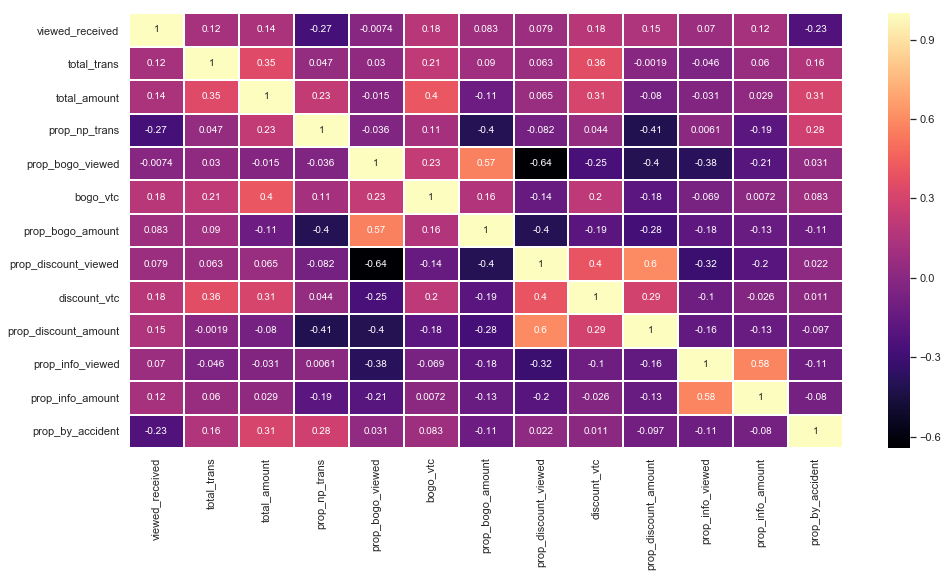

In [6]:
"""show correlation between features"""

EDA.plot_num_corrMap(profile, figsize=(16, 8))

**Observation:** There are no very high correlated features that would have to be eliminated.

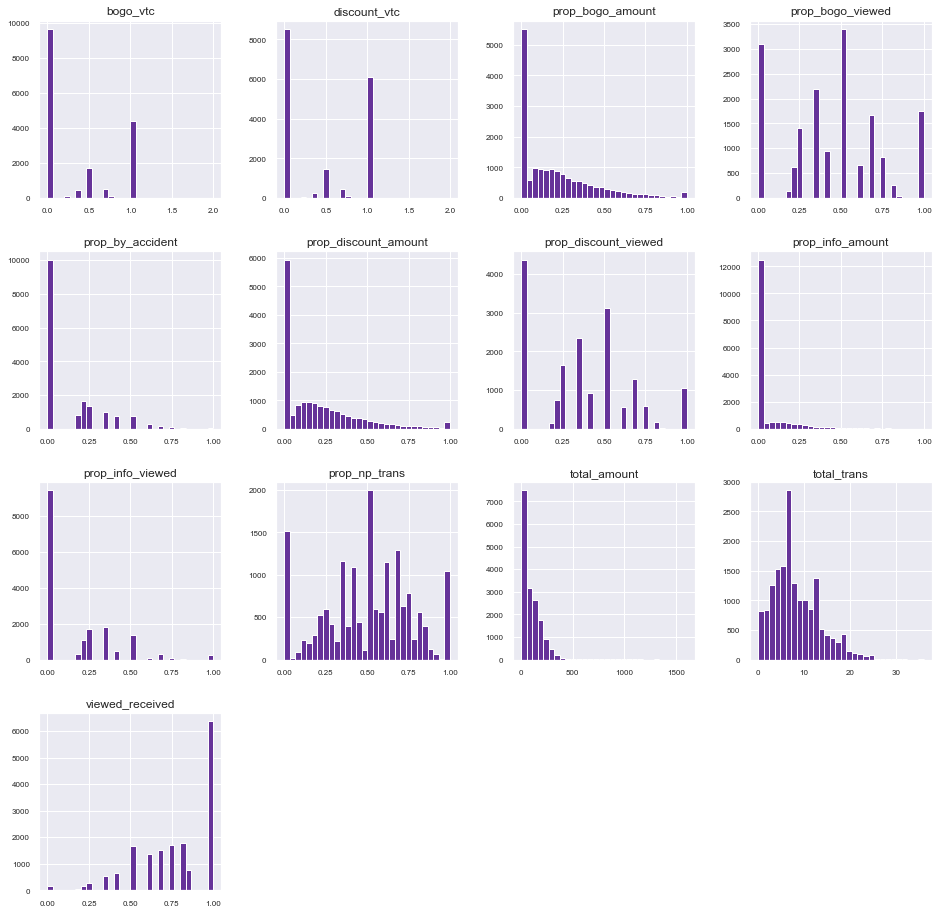

In [7]:
"""plot histograms of numerical data"""

EDA.plot_num_hist(profile, figsize=(16, 16), bins=30)

### Create Test-Set 1: Log-Transformed

In [8]:
"""define log-transformation function"""

def apply_log(df, cols_to_transform=None, treat_NaN=False, rename=False):
    """Transform values of selected columns to natural log. NaN are not 
    affected by default, parameter can be changed. Returns a transformed 
    DataFrame, column names have "_log" appended if parameter is set.

    ARGUMENTS:
        df: DataFrame
        cols_to_transform: list of columns that will have log-transformation 
            applied. Default is all numerical columns.
        treat_NaN: bool, set NaN to small negative value (default=False)
        rename: bool, rename column with appendix (default=False)

    RETURNS:
        df: log-transformed dataframe
    """

    cols_to_transform = cols_to_transform if cols_to_transform is not None else \
        list(df.select_dtypes(include = ['float64', 'int64']).columns)

    for col in df[cols_to_transform]:
        if col in df:
            df[col] = df[col].apply(lambda x: np.log(max(x,0.01)))
            if treat_NaN:
                df[col].replace(np.nan, -1, inplace=True)
        else:
            display(col + " not found")

        #rename transformed columns
        if rename:
            df.rename(columns={col: col+'_log'}, inplace=True)

    return df

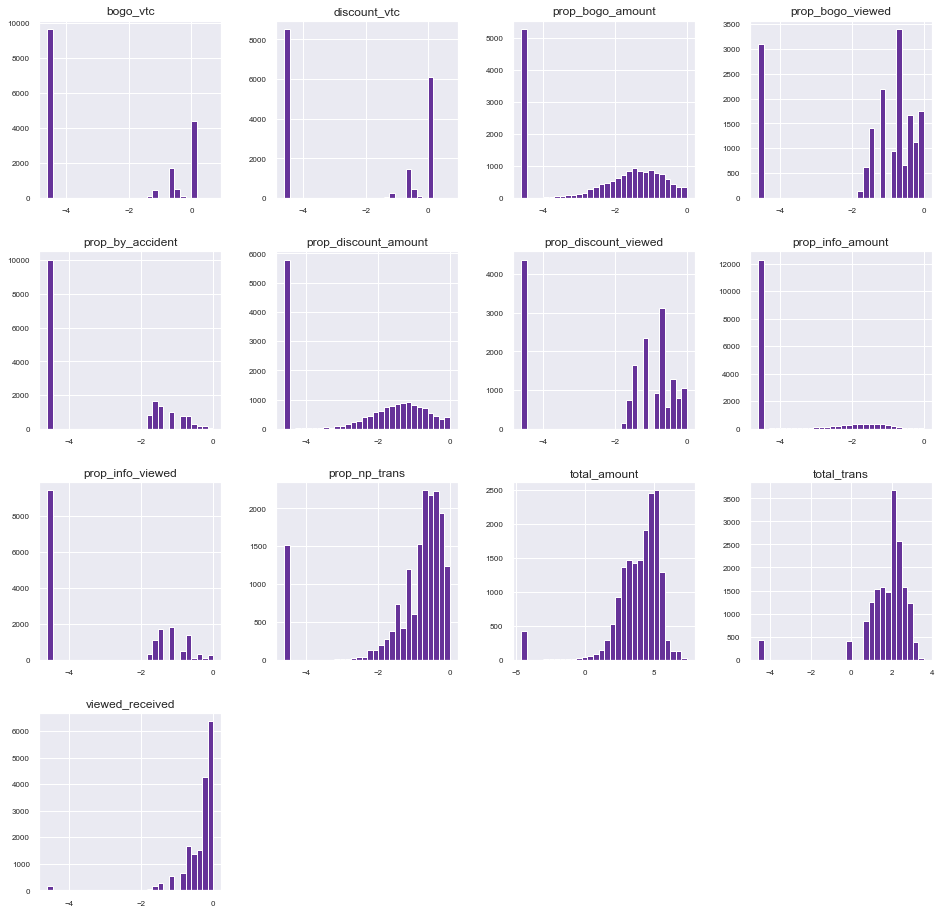

In [9]:
# apply function for transformation on all columns (not only on selection as in experimental notebook)
log_profile = apply_log(profile.copy())
# check results
EDA.plot_num_hist(log_profile, figsize=(16, 16), bins=30)

In [10]:
"""remove oultiers"""

# count outliers (<> IQR=1.5)
cleaning.count_outliers_IQR_method(log_profile)

viewed_received
Identified outliers: 654
Percentage of outliers: 3.8%

total_trans
Identified outliers: 422
Percentage of outliers: 2.5%

total_amount
Identified outliers: 513
Percentage of outliers: 3.0%

prop_np_trans
Identified outliers: 1756
Percentage of outliers: 10.3%

prop_bogo_viewed
Identified outliers: 3087
Percentage of outliers: 18.2%

bogo_vtc
Identified outliers: 0
Percentage of outliers: 0.0%

prop_bogo_amount
Identified outliers: 0
Percentage of outliers: 0.0%

prop_discount_viewed
Identified outliers: 0
Percentage of outliers: 0.0%

discount_vtc
Identified outliers: 0
Percentage of outliers: 0.0%

prop_discount_amount
Identified outliers: 0
Percentage of outliers: 0.0%

prop_info_viewed
Identified outliers: 0
Percentage of outliers: 0.0%

prop_info_amount
Identified outliers: 122
Percentage of outliers: 0.7%

prop_by_accident
Identified outliers: 0
Percentage of outliers: 0.0%



In [11]:
# clean outliers for total transactions, total amount, prop_info_amount
cleaning.remove_outliers_IQR_method(log_profile, outlier_cols=['total_amount', 'total_trans'])
len(log_profile)

total_amount
Rows removed: 513

total_trans
Rows removed: 338


Rows removed in total: 851



16149

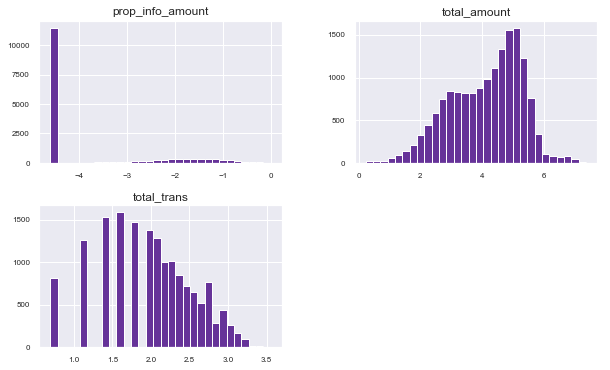

In [12]:
# check results
EDA.plot_num_hist(log_profile[['total_amount', 'total_trans', 'prop_info_amount']], figsize=(10, 6), bins=30)

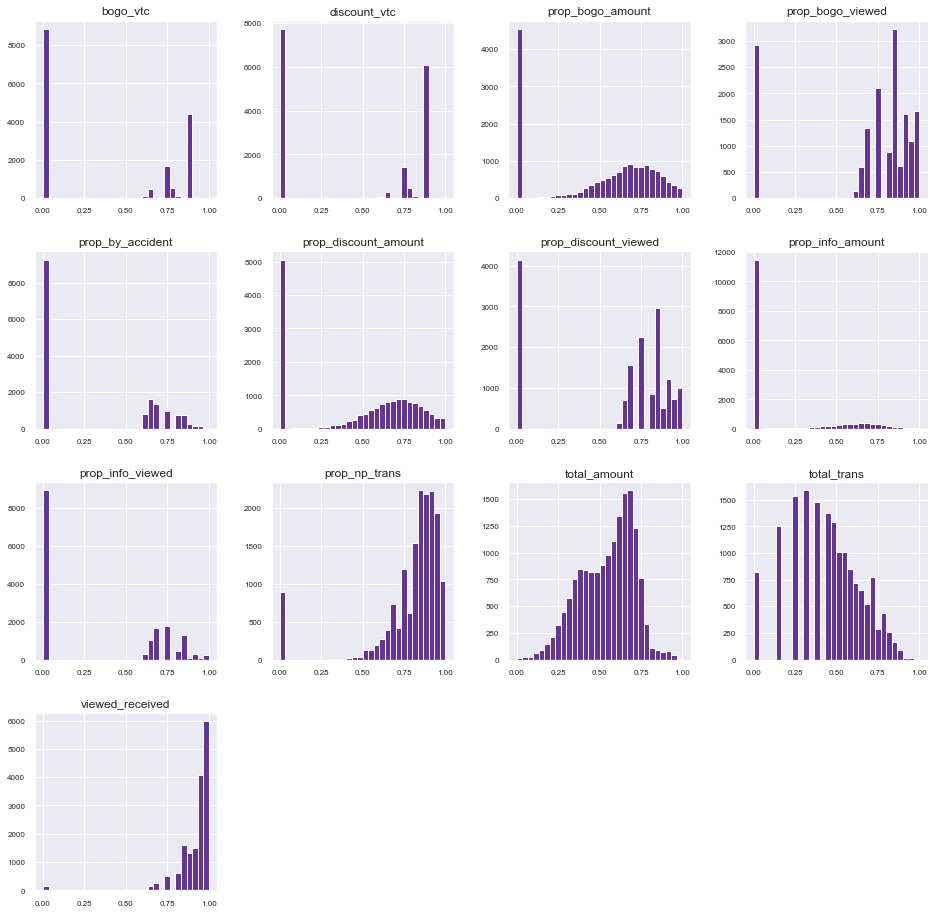

In [13]:
"""scale data to range (0,1)"""

log_scaled_profile = minmax_scale(log_profile)
log_scaled_profile = pd.DataFrame(log_scaled_profile, columns=profile.columns, index=log_profile.index)

# check results
EDA.plot_num_hist(log_scaled_profile, figsize=(16, 16), bins=30)

### Create Test-Set 3: Box-Cox-Transformed

In [14]:
"""define box-cox-transformation function"""

def apply_box_cox(df, cols_to_transform=None, treat_NaN=False, rename=False):
    """Transform values of selected columns with box-cox Returns transformed 
    DataFrame, column names have "_bc" appended if parameter is set.
    # NaN are not affected by default, parameter can be changed. HAVE TO CHECK THIS!

    ARGUMENTS:
        df: DataFrame
        cols_to_transform: list of columns that will have bc-transformation 
            applied. Default is all numerical columns.
        treat_NaN: bool, set NaN to small negative value (default=False)
        rename: bool, rename column with appendix (default=False)

    RETURNS:
        df: box-cox-transformed dataframe
    """

    cols_to_transfrom = cols_to_transform if cols_to_transform is not None else \
        list(df.select_dtypes(include = ['float64', 'int64']).columns)

    for col in df[cols_to_transform]:
        if col in df:
            df[col] = df[col].apply(lambda x : x + 0.01 if x == 0 else x)
            df[col] = stats.boxcox(df[col])[0]
        else:
            display(col + " not found")

        #rename transformed columns
        if rename:
            df.rename(columns={col: col+'_bc'}, inplace=True)

    return df

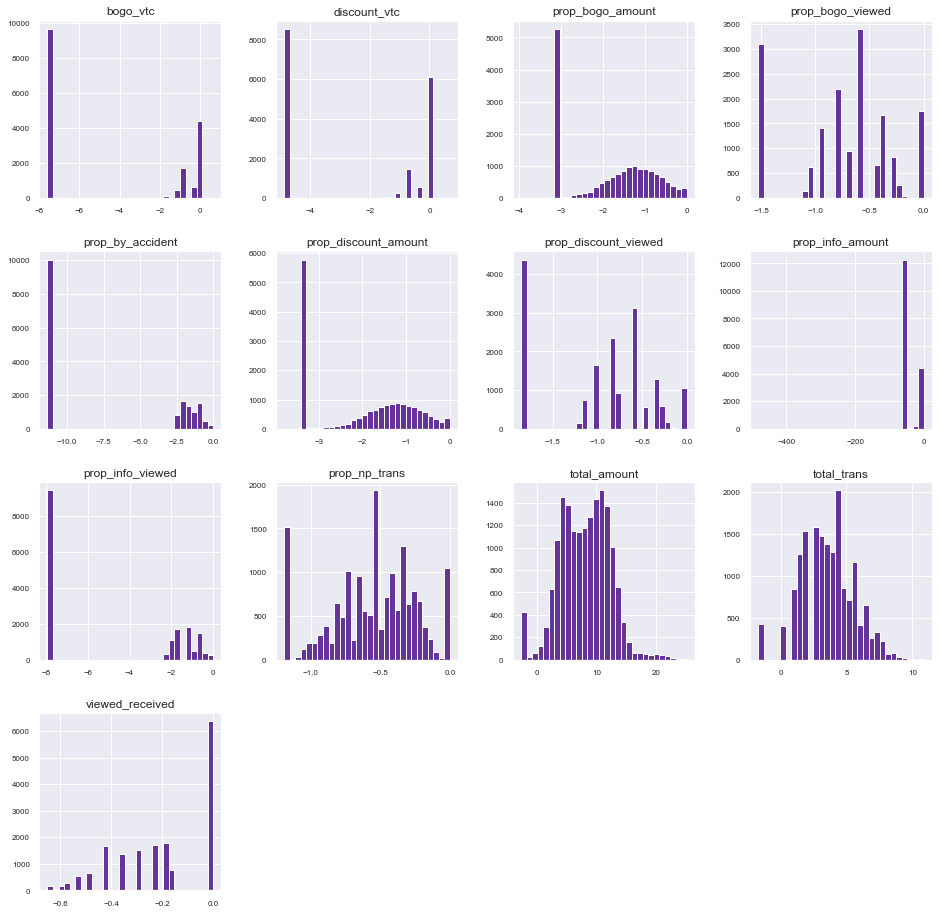

In [15]:
# apply function for transformation on all columns (not only on selection as in experimental notebook)
bc_profile = apply_box_cox(profile.copy(), cols_to_transform=profile.columns)

# check results
EDA.plot_num_hist(bc_profile, figsize=(16, 16), bins=30)

In [16]:
"""remove outliers"""

cleaning.remove_outliers_IQR_method(bc_profile, outlier_cols=['total_amount', 'total_trans', 'prop_info_amount'])
len(bc_profile)

total_amount
Rows removed: 106

total_trans
Rows removed: 25

prop_info_amount
Rows removed: 14


Rows removed in total: 145



16855

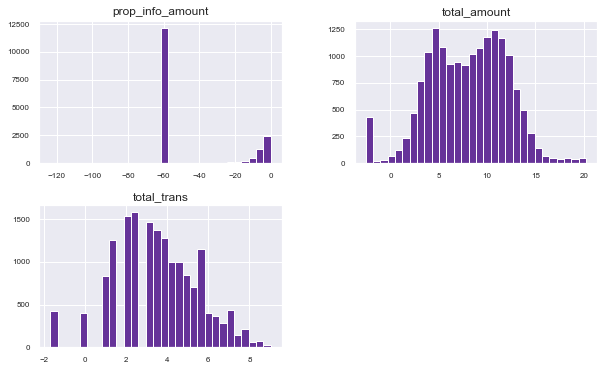

In [17]:
# check results
EDA.plot_num_hist(bc_profile[['total_amount', 'total_trans', 'prop_info_amount']], figsize=(10, 6), bins=30)

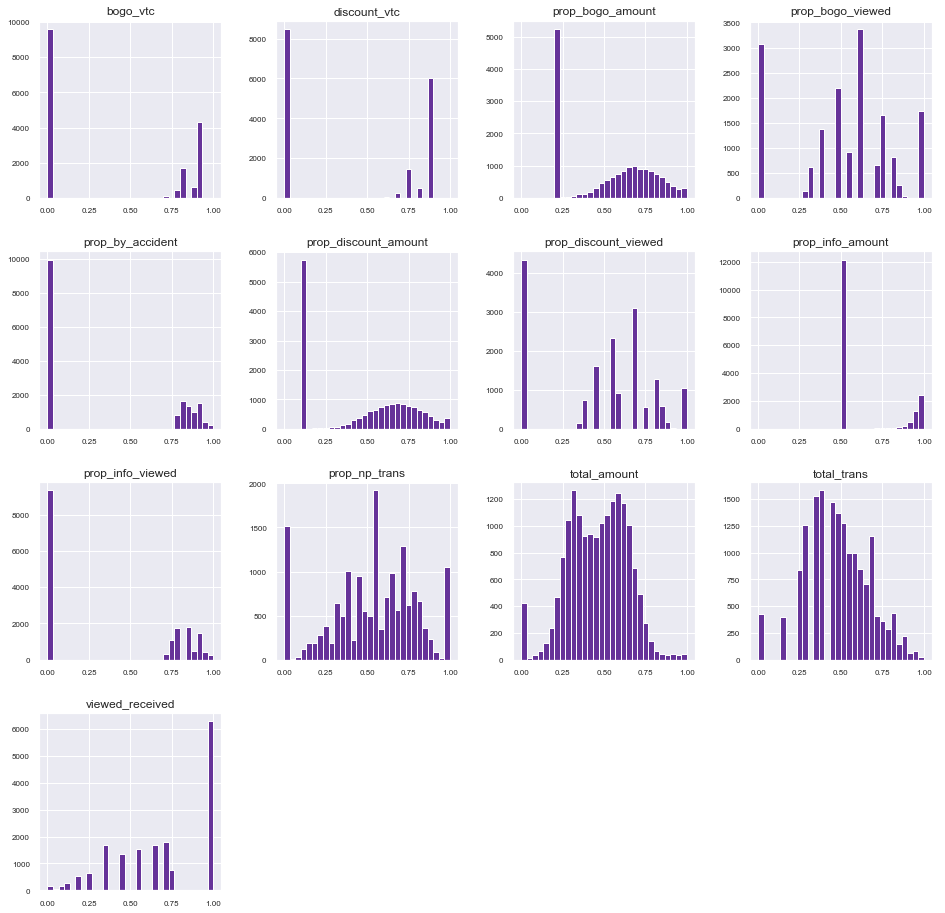

In [18]:
"""scale data to range (0,1)"""

bc_scaled_profile = minmax_scale(bc_profile)
bc_scaled_profile = pd.DataFrame(bc_scaled_profile, columns=profile.columns)

# check results
EDA.plot_num_hist(bc_scaled_profile, figsize=(16, 16), bins=30)

### Create Test-Set 4: Yeo-Johnson-transformed

In [19]:
"""define yeo-johnson-transformation function"""

def apply_yeo_j(df, cols_to_transform=None, treat_NaN=False, rename=False):
    """Transform values of selected columns with box-cox Returns transformed 
    DataFrame, column names have "_yj" appended if parameter is set.
    # NaN are not affected by default, parameter can be changed. HAVE TO CHECK THIS!

    ARGUMENTS:
        df: DataFrame
        cols_to_transform: list of columns that will have bc-transformation 
            applied. Default is all numerical columns.
        treat_NaN: bool, set NaN to small negative value (default=False)
        rename: bool, rename column with appendix (default=False)

    RETURNS:
        df: box-cox-transformed dataframe
    """

    cols_to_transfrom = cols_to_transform if cols_to_transform is not None else \
        list(df.select_dtypes(include = ['float64', 'int64']).columns)

    for col in df[cols_to_transform]:
        if col in df:
            df[col] = stats.yeojohnson(df[col])[0]
        else:
            display(col + " not found")

        #rename transformed columns
        if rename:
            df.rename(columns={col: col+'_yj'}, inplace=True)

    return df

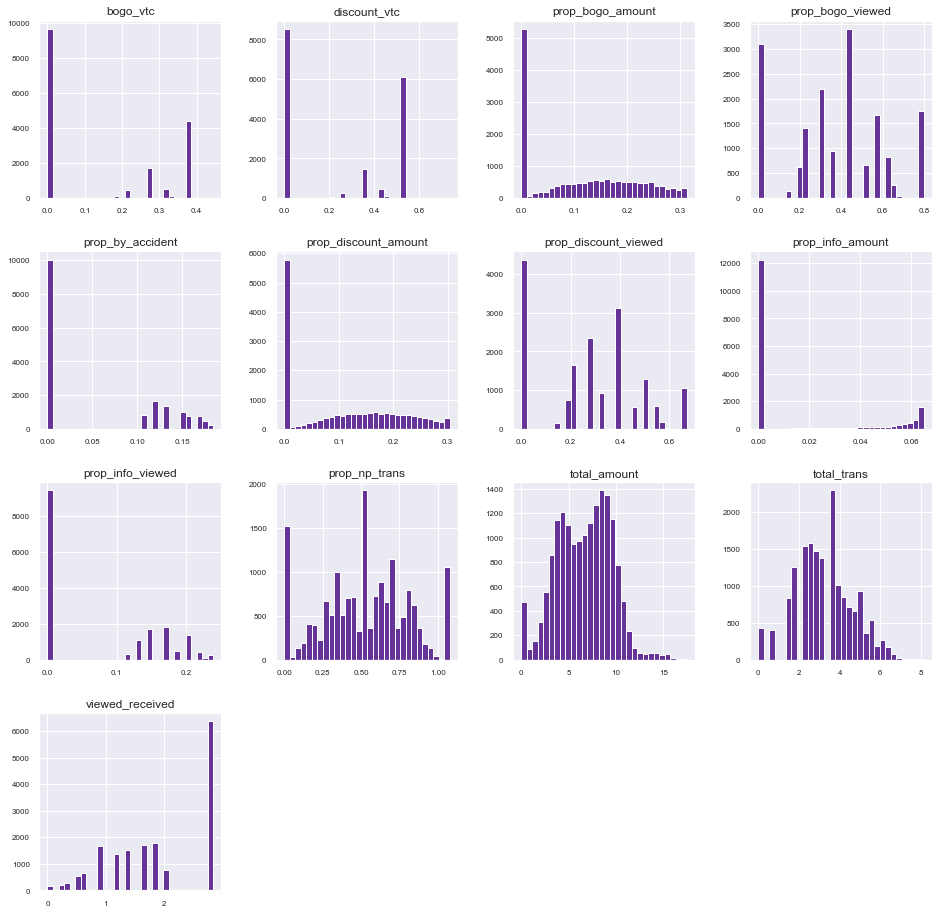

In [20]:
# apply function for transformation all columns (not only on selection as in experimental notebook)
yj_profile = apply_yeo_j(profile.copy(), cols_to_transform=profile.columns)

# check results
EDA.plot_num_hist(yj_profile, figsize=(16, 16), bins=30)

In [21]:
"""remove oultiers"""

cleaning.remove_outliers_IQR_method(yj_profile, outlier_cols=['total_amount', 'total_trans', 'prop_info_amount'])
len(yj_profile)

total_amount
Rows removed: 46

total_trans
Rows removed: 18

prop_info_amount
Rows removed: 0


Rows removed in total: 64



16936

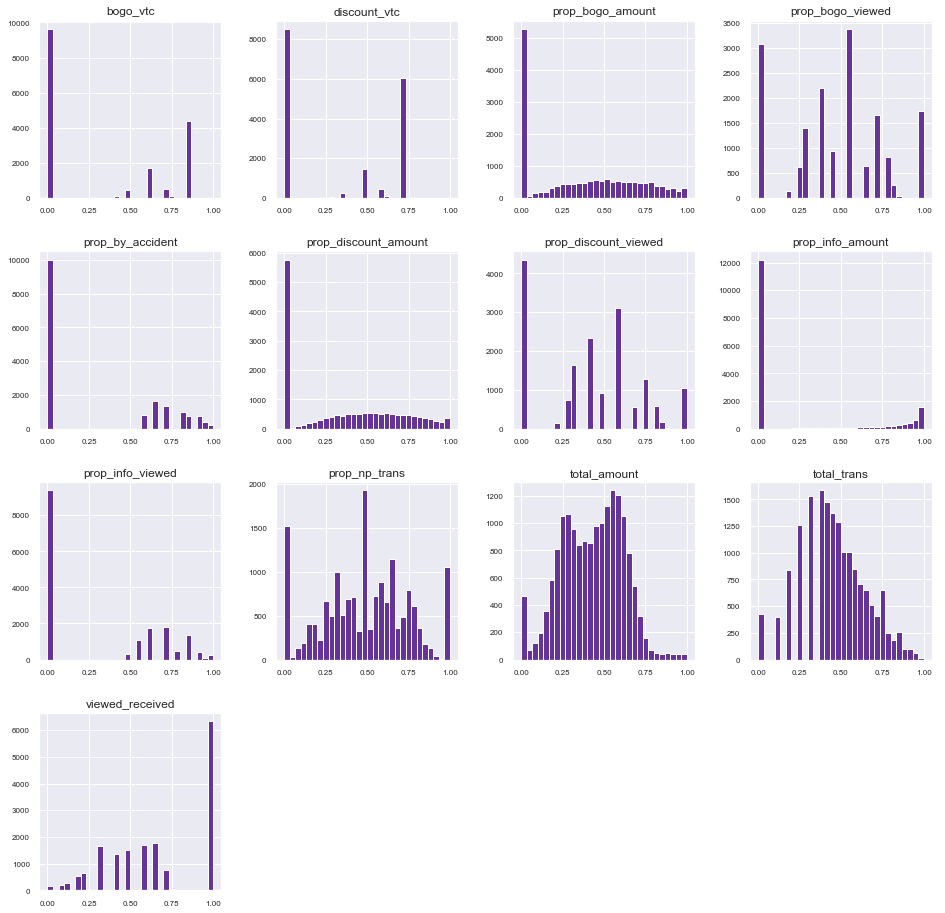

In [22]:
"""scale data to range (0,1)"""

yj_scaled_profile = minmax_scale(yj_profile)
yj_scaled_profile = pd.DataFrame(yj_scaled_profile, columns=profile.columns)

# check results
EDA.plot_num_hist(yj_scaled_profile, figsize=(16, 16), bins=30)

## Apply PCA


**Note:** According to sklearn-docu: The optional parameter `whiten=True` makes it possible to project the data onto the singular space while scaling each component to unit variance. This is often useful if the models down-stream make strong assumptions on the isotropy of the signal: this is for example the case for Support Vector Machines with the RBF kernel and the K-Means clustering algorithm.

`whiten` was tested for k-means clustering but did not perform at all

In [23]:
""" apply PCA with the goal to retain 95% of the variance"""

# initialize pca class object
pca = PCA(n_components=0.95) # PCA(n_components=bc_profile.shape[1])

# define function to apply pca and visualize the results
def pca_results(df, pca):
    ''' Create a DataFrame of the PCA results that includes dimension feature 
    weights and explained variance and visusalize the results with a bar chart.

    ARGUMENTS:
        - df: dataframe
        - pca: fitted sklearn PCA class object
        
    RETURNS:
        - pca_results: dataframe with pca results
        - Plot of PCA results (bar chart)
    '''
    
    pca.fit(df)

    # index dimensions, pca components, explained variance
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    components = pd.DataFrame(np.round(pca.components_, 4), columns = list(df.keys()))
    components.index = dimensions
    
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # create a bar plot visualization: plot feature weights as function of components
    fig, ax = plt.subplots(figsize = (18,12))

    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)
    plt.legend(loc='lower right')

    # display explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n%.4f"%(ev))

    # return concatenated DataFrame
    pca_results = pd.concat([variance_ratios, components], axis = 1)
    pca_results

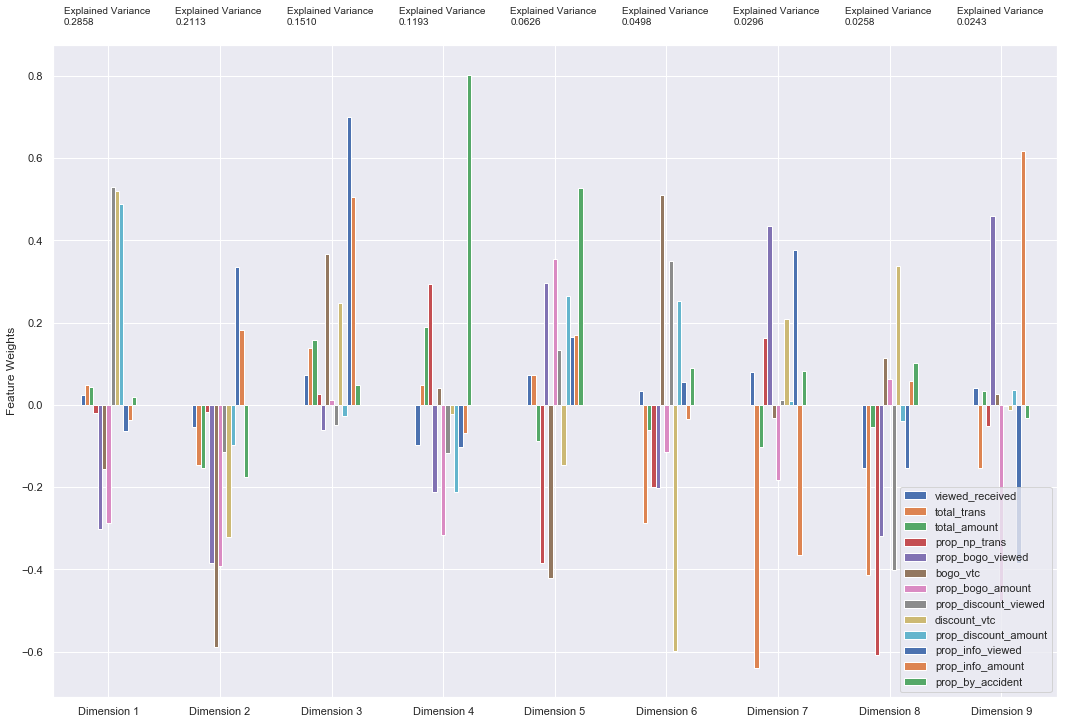

In [24]:
# call function
pca_results(log_scaled_profile, pca)

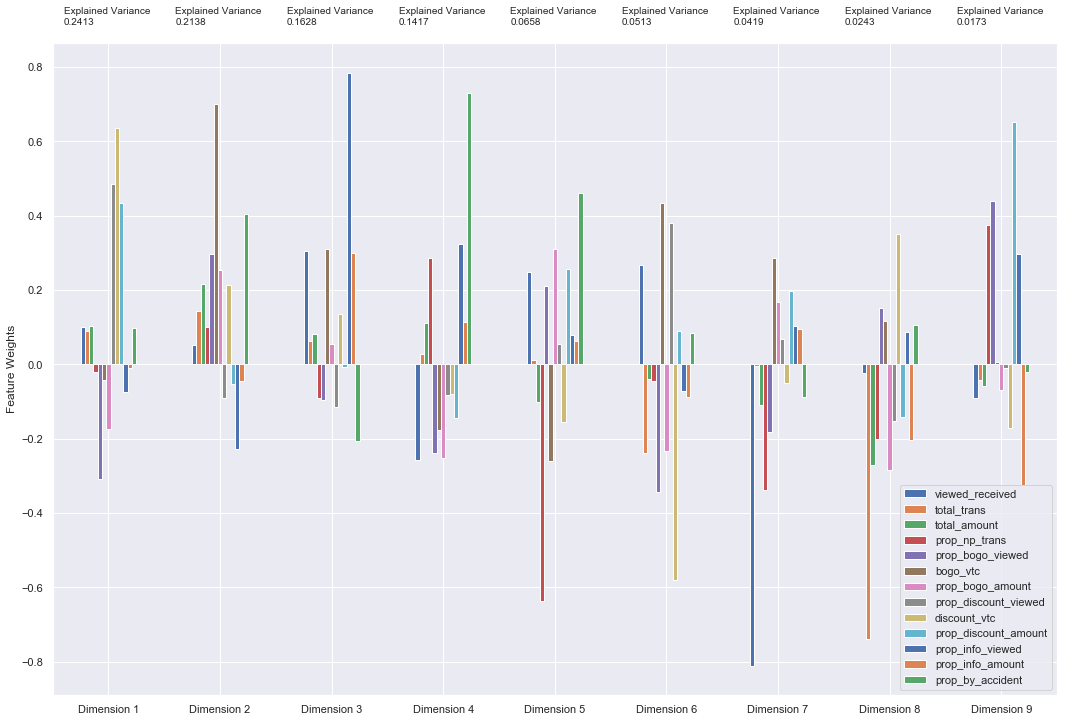

In [25]:
# call function
pca_results(bc_scaled_profile, pca)

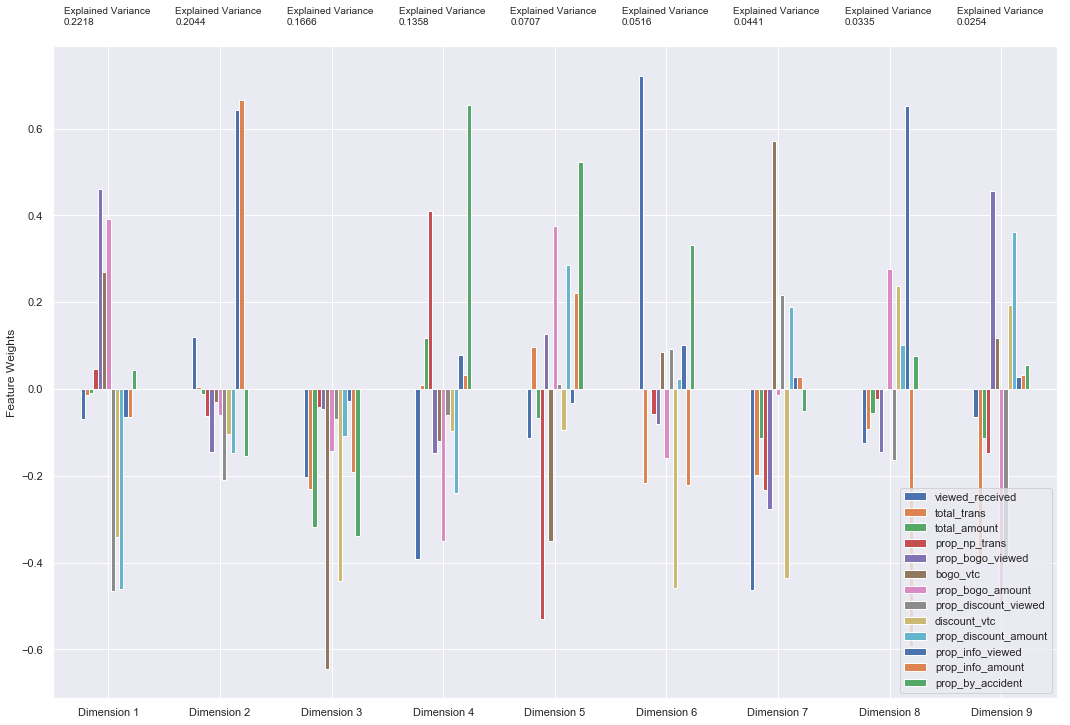

In [26]:
# call function
pca_results(yj_scaled_profile, pca)

### Visualize (massive) PCA-Reduction with Bi-Plot

**Note:** The optional parameter `whiten=True` makes it possible to project the data onto the singular space while scaling each component to unit variance. This is often useful if the models down-stream make strong assumptions on the isotropy of the signal: this is for example the case for Support Vector Machines with the RBF kernel and the K-Means clustering algorithm.

`whiten` was tested for k-means clustering but did not perform at all

In [27]:
"""def function to visualize pca-reduction"""

def create_biplot(orig_df, reduced_df, pca):
    '''Create a biplot that shows a scatterplot of the reduced
    data and the projections of the original features.

    ARGUMENTS:
        - orig_df: dataframe before pca-transformation with column names
        - reduced_df: dataframe after pca-transformation (the first 2D are plotted)
        - pca: sklearn PCA object that contains the components_ attribute

    RETURNS:
        - a matplotlib AxesSubplot object (for any additional customization)

    This procedure is inspired by the script:
    https://github.com/teddyroland/python-biplot
    '''

    fig, ax = plt.subplots(figsize = (18,12))

    # scatterplot of the reduced data    
    ax.scatter(x=reduced_df.loc[:, 'Dimension 1'], y=reduced_df.loc[:, 'Dimension 2'], 
        facecolors='b', edgecolors='b', s=50, alpha=0.5)

    # scaling factors to make the arrows easier to see
    arrow_size, text_pos = 1.5, 1.5

    # projections of the original features
    feature_vectors = pca.components_.T
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.1, head_length=0.1, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, orig_df.columns[i], color='black', 
                 ha='center', va='bottom', fontsize=16)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);

    return ax

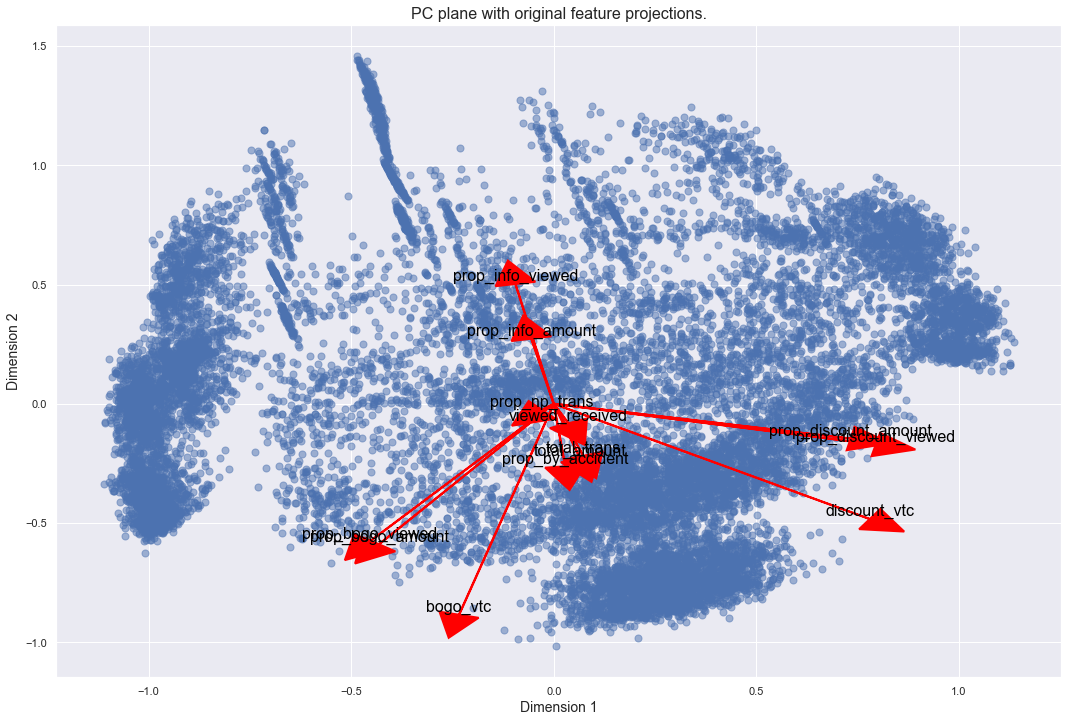

In [28]:
"""visualize for log_scaled"""

pca_2 = PCA(n_components=2)
reduced_profile = pca_2.fit_transform(log_scaled_profile)
reduced_profile = pd.DataFrame(reduced_profile, columns=['Dimension 1', 'Dimension 2'])

# call function
create_biplot(profile, reduced_profile, pca_2);

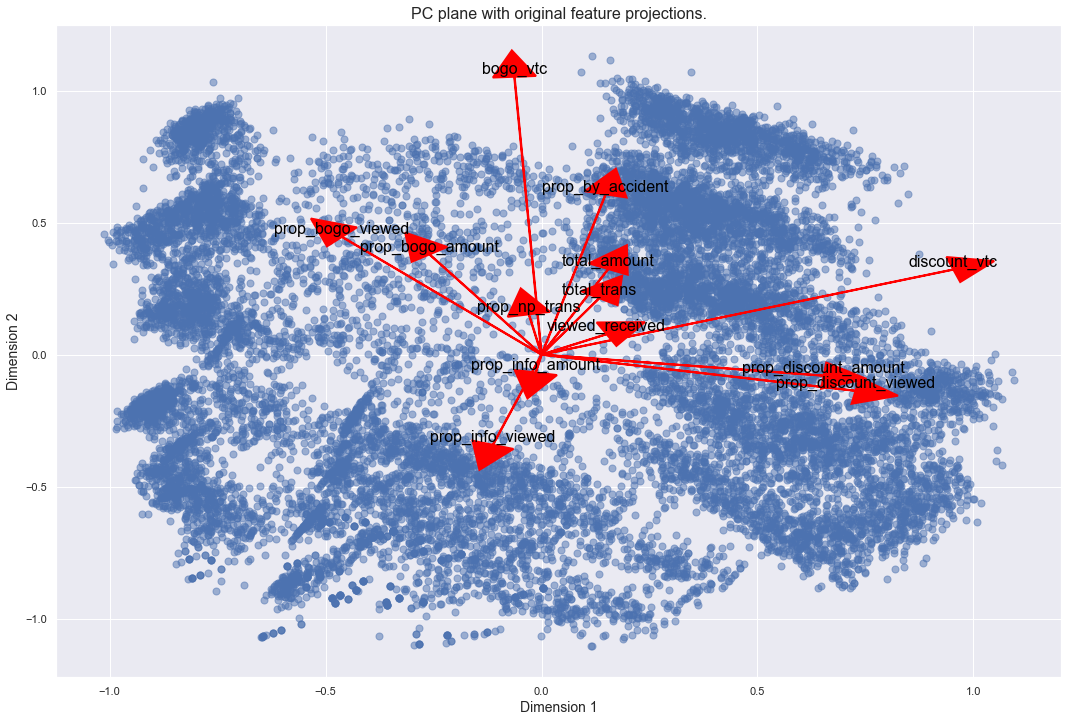

In [29]:
"""visualize for bc_scaled"""

pca_2 = PCA(n_components=2)
reduced_profile = pca_2.fit_transform(bc_scaled_profile)
reduced_profile = pd.DataFrame(reduced_profile, columns=['Dimension 1', 'Dimension 2'])

# call function
create_biplot(profile, reduced_profile, pca_2);

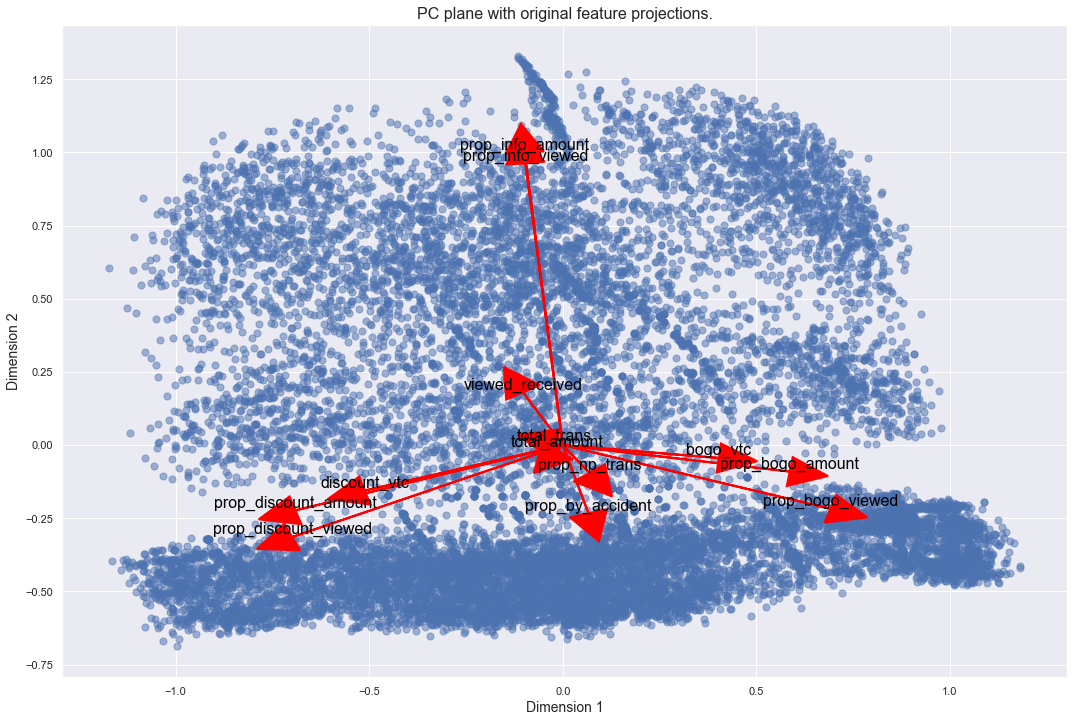

In [30]:
"""visualize for yj_scaled"""

pca_2 = PCA(n_components=2)
reduced_profile = pca_2.fit_transform(yj_scaled_profile)
reduced_profile = pd.DataFrame(reduced_profile, columns=['Dimension 1', 'Dimension 2'])

# call function
create_biplot(profile, reduced_profile, pca_2);

## Apply k-means Clustering

In [31]:
pca_4 = PCA(n_components=4)

In [32]:
# transform the scaled BC data using the PCA fit with 4 comp
reduced_bc_profile_4 = pca_4.fit_transform(bc_scaled_profile)

# apply k-means to the reduced data, output silhouette score for different cluster numbers
range_n_clusters = [4, 6, 8, 10]

for nc in range_n_clusters:
    kmeans = KMeans(n_clusters=nc)   
    kmeans.fit(reduced_bc_profile_4)

    # predict the cluster for each data point
    preds = kmeans.predict(reduced_bc_profile_4)
    # find the cluster centers
    centers = kmeans.cluster_centers_ 
    # calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_bc_profile_4, preds)

    print(nc, score)

4 0.28340733281631736
6 0.3123091218724075
8 0.3483616512692779
10 0.39037595955103344


In [33]:
# transform the scaled BC data using the PCA fit with 2 comp
reduced_bc_profile_2 = pca_2.fit_transform(bc_scaled_profile)

# apply k-means to the reduced data, output silhouette score for different cluster numbers


range_n_clusters = [4, 6, 8, 10, 12]

for nc in range_n_clusters:
    kmeans = KMeans(n_clusters=nc)   
    kmeans.fit(reduced_bc_profile_2)

    # predict the cluster for each data point
    preds = kmeans.predict(reduced_bc_profile_2)
    # find the cluster centers
    centers = kmeans.cluster_centers_ 
    # calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_bc_profile_2, preds)

    print(nc, score)

4 0.49903572621681436
6 0.41487848991073856
8 0.3683687634563905
10 0.3931675078748204
12 0.41180796609231657


In [34]:
# transform the scaled LOG data using the PCA fit with 4 comp
reduced_log_profile_4 = pca_4.fit_transform(log_scaled_profile)

# apply k-means to the reduced data, output silhouette score for different cluster numbers
range_n_clusters = [4, 6, 8, 10, 12]

for nc in range_n_clusters:
    kmeans = KMeans(n_clusters=nc)   
    kmeans.fit(reduced_log_profile_4)

    # predict the cluster for each data point
    preds = kmeans.predict(reduced_log_profile_4)
    # find the cluster centers
    centers = kmeans.cluster_centers_ 
    # calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_log_profile_4, preds)

    print(nc, score)

4 0.294658065922394
6 0.3201658319921811
8 0.34487860567819906
10 0.34333273829785166
12 0.35622741909985844


In [35]:
# transform the scaled LOG data using the PCA fit with 2 comp
reduced_log_profile_2 = pca_2.fit_transform(log_scaled_profile)

# apply k-means to the reduced data, output silhouette score for different cluster numbers
range_n_clusters = [4, 6, 8, 10, 12]

for nc in range_n_clusters:
    kmeans = KMeans(n_clusters=nc)   
    kmeans.fit(reduced_log_profile_2)

    # predict the cluster for each data point
    preds = kmeans.predict(reduced_log_profile_2)
    # find the cluster centers
    centers = kmeans.cluster_centers_ 
    # calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_log_profile_2, preds)

    print(nc, score)

4 0.49757689229086555
6 0.44155213961750966
8 0.42761982742317706
10 0.4382617634886965
12 0.4548362864936317


### Apply hierarchical clustering

Note: `complete` linkage was tried, did not perform at all

In [36]:
from sklearn.cluster import AgglomerativeClustering

n_clusters=6

# Ward is the default linkage algorithm, so we'll start with that
ward = AgglomerativeClustering(n_clusters=n_clusters)
ward_bc = ward.fit_predict(reduced_bc_profile_2)
ward_log = ward.fit_predict(reduced_log_profile_2)

# average linkage
avg = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
avg_bc = avg.fit_predict(reduced_bc_profile_2)
avg_log = avg.fit_predict(reduced_log_profile_2)

In [37]:
# calculate the mean silhouette coefficient for the number of clusters chosen
print(silhouette_score(reduced_bc_profile_2, ward_bc))
print(silhouette_score(reduced_log_profile_2, ward_log))

0.37400467467015347
0.419084119106375


In [38]:
# calculate the mean silhouette coefficient for the number of clusters chosen
print(silhouette_score(reduced_bc_profile_2, avg_bc))
print(silhouette_score(reduced_log_profile_2, avg_log))

0.37535285798325746
0.44029676872268825


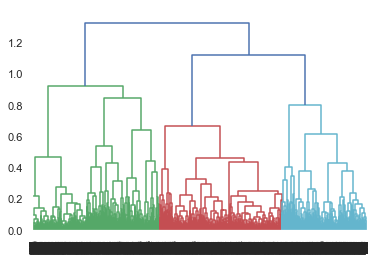

<Figure size 1152x1152 with 0 Axes>

In [39]:
# visualize the hierarchical clustering with scipy
linkage_type = 'average'
linkage_matrix = linkage(reduced_log_profile_2, linkage_type)
dendrogram(linkage_matrix)
plt.figure(figsize=(16,16))
plt.show()

### Append clusters to profile

k-means with 6 clusters on log_scaled_profile, reduced to two pc-dimensions

In [80]:
"""cluster with k-means"""

kmeans = KMeans(n_clusters=12)   
kmeans.fit(reduced_log_profile_2)

# predict the cluster for each data point
preds = kmeans.predict(reduced_log_profile_2)

# calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_log_profile_2, preds)

# safety-check
print(score)

0.4542959800948208


In [81]:
unique, counts = np.unique(preds, return_counts=True)
display(np.asarray((unique, counts)).T)

array([[   0, 2612],
       [   1,  643],
       [   2, 1134],
       [   3, 1028],
       [   4,  859],
       [   5, 1686],
       [   6,  718],
       [   7, 1230],
       [   8, 2372],
       [   9, 1471],
       [  10,  961],
       [  11, 1435]], dtype=int64)

In [82]:
"""append clusters to log_scaled_profile (just to get the right indexes)"""

assert len(preds) == log_scaled_profile.shape[0] # safety-check
log_scaled_profile['cluster'] = preds + 1

# check results
log_scaled_profile['cluster'].value_counts()

1     2612
9     2372
6     1686
10    1471
12    1435
8     1230
3     1134
4     1028
11     961
5      859
7      718
2      643
Name: cluster, dtype: int64

In [97]:
"""create dataframe profile_cluster (re-aranged profile_type with clusters as new column)"""

profile_clusters = pd.concat([profile_type, log_scaled_profile[['cluster']]], axis=1, sort=True)

In [98]:
# save clustered data

profile_type_w_clusters = Path.cwd() / "data" / "processed" / "profile_type_w_clusters.csv"
profile_clusters.to_csv(profile_type_w_clusters)

---